Exploring actual band level data to see what is going on in depth. 

In [4]:
import logging
logger = logging.getLogger("Testing")
logger.setLevel(logging.INFO)
import pathlib
import sys
# Register the parent directory as a path to look for modules
notebook_dir = pathlib.Path().resolve()
parent_dir = notebook_dir.parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))


In [26]:
chosen_file = "../tests/test_payloads/phase_2/Set-1/Hypersepctral Datasets/PRS_L2D_STD_20201214060713_20201214060717_0001.he5"

In [27]:
from app.models.file_processing.sources import FileSourceConfig
# Setting file source
file_source = FileSourceConfig(
    source_path=chosen_file
)
print(file_source.file_category)

FileCategory.HDFS


In [28]:
from string.templatelib import Template
from app.utils.files.he5_helper import HE5Helper
from app.templates.template_mappings import TEMPLATE_MAPPINGS, TemplateIdentifier

helper = HE5Helper(
    file_source_config=file_source,
    template = TEMPLATE_MAPPINGS.get(TemplateIdentifier.PRISMA_HYPERSPECTRAL)
)
print(helper.file_metadata)

components=['HDFEOS', 'HDFEOS/SWATHS', 'HDFEOS/SWATHS/GCP attributes', 'HDFEOS/SWATHS/Geocoding attributes', 'HDFEOS/SWATHS/Geocoding attributes/Ancillary', 'HDFEOS/SWATHS/PRS_L2D_HCO', 'HDFEOS/SWATHS/PRS_L2D_HCO/Data Fields', 'HDFEOS/SWATHS/PRS_L2D_HCO/Data Fields/SWIR_Cube', 'HDFEOS/SWATHS/PRS_L2D_HCO/Data Fields/SWIR_PIXEL_L2_ERR_MATRIX', 'HDFEOS/SWATHS/PRS_L2D_HCO/Data Fields/VNIR_Cube', 'HDFEOS/SWATHS/PRS_L2D_HCO/Data Fields/VNIR_PIXEL_L2_ERR_MATRIX', 'HDFEOS/SWATHS/PRS_L2D_HCO/Geocoding Model', 'HDFEOS/SWATHS/PRS_L2D_HCO/Geolocation Fields', 'HDFEOS/SWATHS/PRS_L2D_HCO/Geolocation Fields/Latitude', 'HDFEOS/SWATHS/PRS_L2D_HCO/Geolocation Fields/Longitude', 'HDFEOS/SWATHS/PRS_L2D_HCO/Geolocation Fields/Time', 'HDFEOS/SWATHS/PRS_L2D_HCO/Geometric Fields', 'HDFEOS/SWATHS/PRS_L2D_HCO/Geometric Fields/Observing_Angle', 'HDFEOS/SWATHS/PRS_L2D_HCO/Geometric Fields/Rel_Azimuth_Angle', 'HDFEOS/SWATHS/PRS_L2D_HCO/Geometric Fields/Solar_Zenith_Angle', 'HDFEOS/SWATHS/PRS_L2D_PCO', 'HDFEOS/SWAT

In [29]:
from app.models.hyperspectral_concepts.spectral_family import SpectralFamily
swir_cube = helper.extract_specific_bands(
    bands = [1],
    masking_needed=True,
    spectral_family=SpectralFamily.SWIR,
    mode="all"
)

print(f"SWIR Cube Shape : {swir_cube.shape}")

SWIR Cube Shape : (1186, 173, 1196)


In [30]:
vnir_cube = helper.extract_specific_bands(
    bands = [1],
    masking_needed=True,
    spectral_family=SpectralFamily.VNIR,
    mode="all"
)
print(f"VNIR Cube Shape : {vnir_cube.shape}")

VNIR Cube Shape : (1186, 66, 1196)


In [31]:
import numpy as np
# Attaching VNIR and SWIR Cube
combined_cube = np.ma.concatenate(
    [swir_cube, vnir_cube], axis = 1
)
print(f"Combined Cube Shape: {combined_cube.shape}")

Combined Cube Shape: (1186, 239, 1196)


In [32]:
from app.models.images.cube_representation import CubeRepresentation
from app.utils.data_transformations.prs_l2d_dn_to_surface_reflectance_transformer import PrsL2dDnToSurfaceReflectanceTransformer

transformer = PrsL2dDnToSurfaceReflectanceTransformer()
band_mappings = [SpectralFamily.SWIR] * swir_cube.shape[1] + [SpectralFamily.VNIR] * vnir_cube.shape[1]

transformed_cube = transformer.transform(
    input_data=combined_cube,
    cube_representation=CubeRepresentation.BIL,
    file_metadata=helper.file_metadata,
    band_mapping=band_mappings,
    masking_indicator= 0.0
)

Using device: mps


In [52]:
print(f"Transformed Cube Shape: {transformed_cube.shape}")
print(f"Min: {transformed_cube.data.min()}")
print(f"Max: {transformed_cube.data.max()}")
sample_value = transformed_cube[700,200,700]
print(f"Sample Value = {sample_value}")

Transformed Cube Shape: (1186, 239, 1196)
Min: 0.0
Max: 1.0
Sample Value = 0.13263671100139618


In [54]:
from matplotlib import pyplot as plt
from app.utils.image_transformation.image_cube_operations import ImageCubeOperations
cube_maker = ImageCubeOperations()
visual_cube = cube_maker.convert_cube(
    cube=transformed_cube,
    from_format=CubeRepresentation.BIL,
    to_format=CubeRepresentation.BIP,
    output_form="numpy"
)
raw_cube = cube_maker.convert_cube(
    cube=combined_cube,
    from_format=CubeRepresentation.BIL,
    to_format=CubeRepresentation.BIP,
    output_form="numpy"
)
print(f"Visual Cube Shape: {visual_cube.shape}")

Using device: mps
Visual Cube Shape: (1186, 1196, 239)


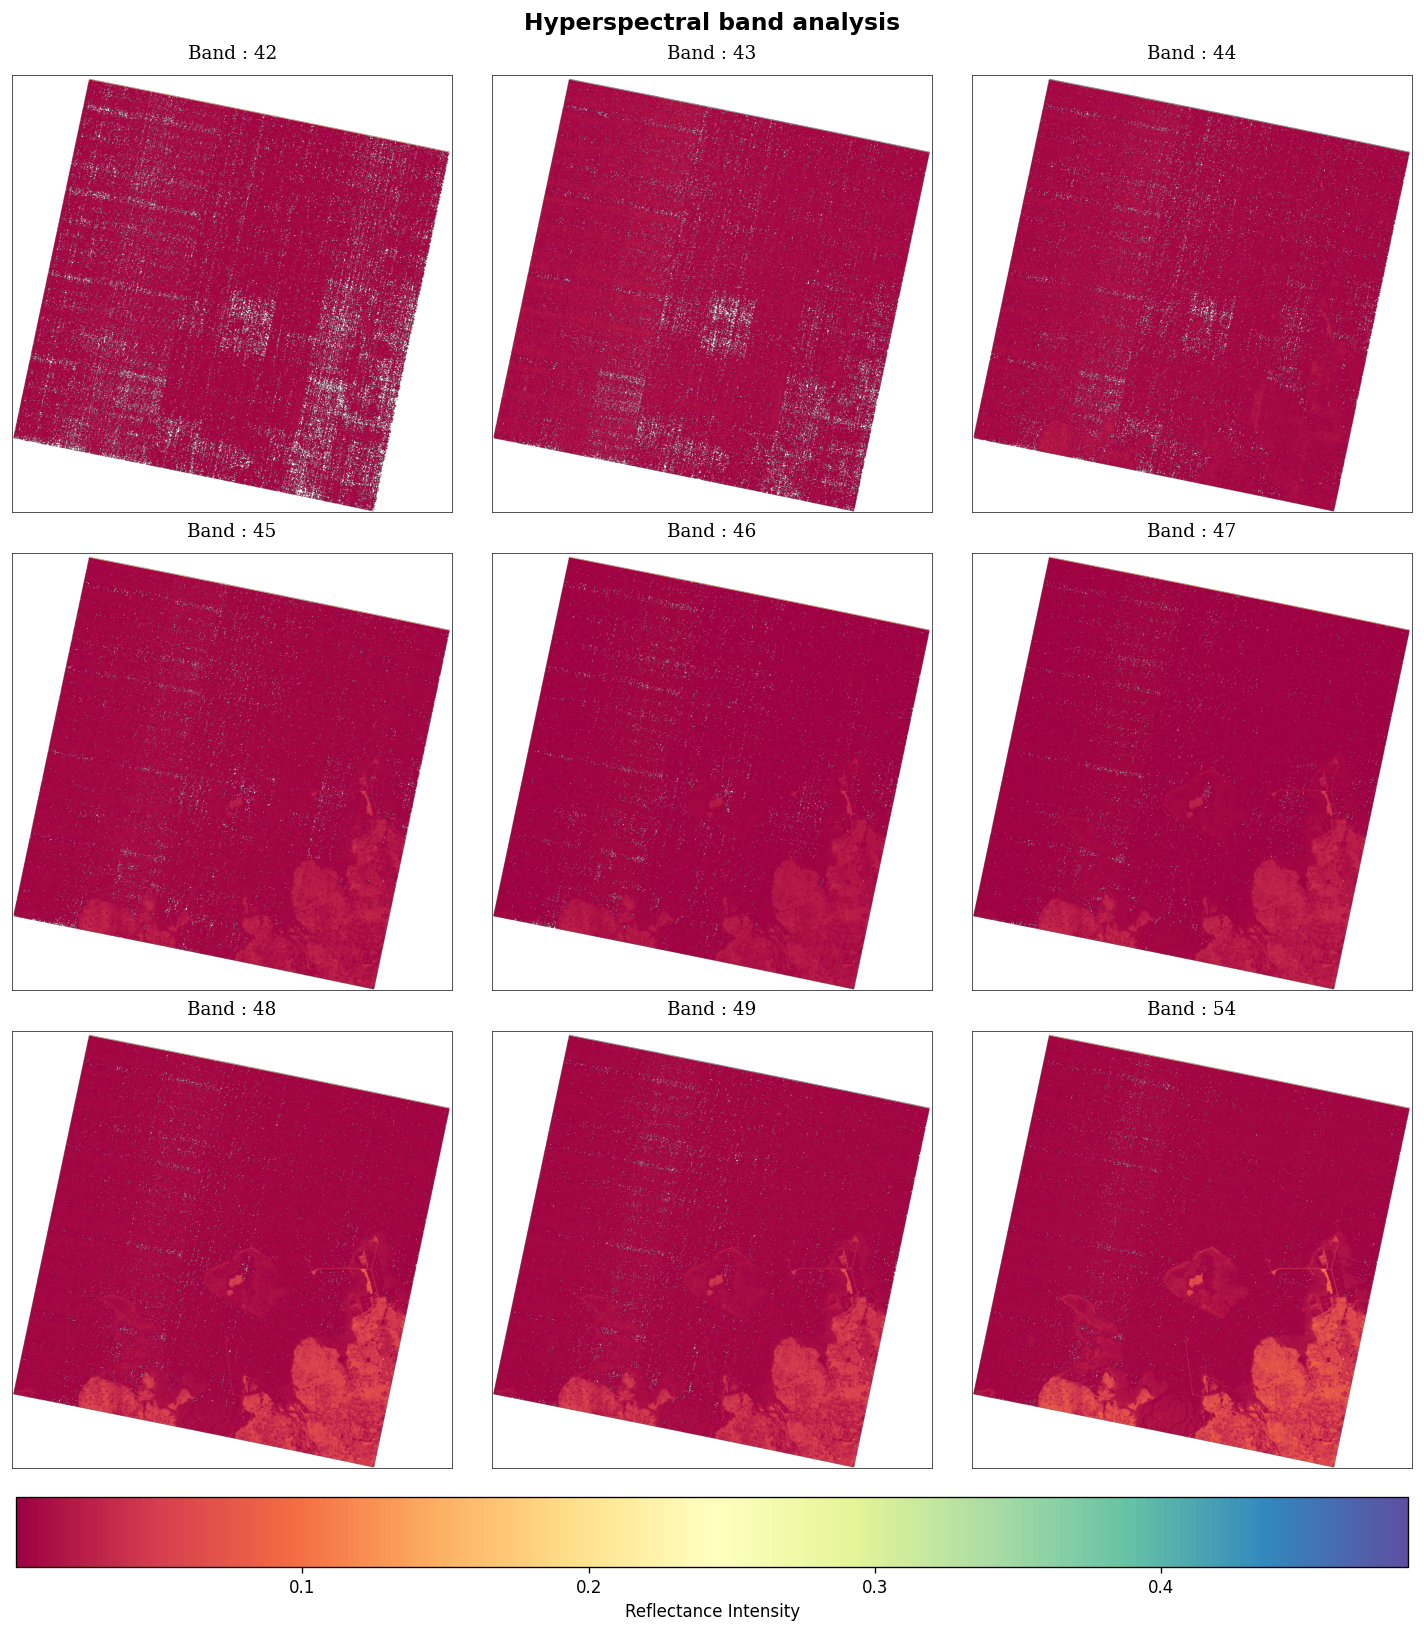

In [ ]:
import math
bands_to_visualize = [14, 24, 29, 34, 39, 44, 49, 54, 59]
num_plots = len(bands_to_visualize)
num_rows = math.ceil(num_plots / 3)

# Set up the plot
# Set up the plot
fig, axes = plt.subplots(
    num_rows,
    3,
    figsize=(4 * 3, 4.5 * num_rows),
    constrained_layout=True,
    dpi=120,
)

fig.suptitle(
    f"Hyperspectral band analysis",
    fontsize=14,
    fontweight="bold",
)
axes_flat = axes.flatten() if num_plots > 1 else [axes]
plot_images = []


## Do the actual plotting
for i, ax in enumerate(axes_flat):
    if i < num_plots:
        single_band = visual_cube[:,:,i]
        im = ax.imshow(single_band, cmap="Spectral")
        plot_images.append(im)
        label_text = f"Band : {bands_to_visualize[i]}"
        ax.set_title(label_text, fontsize=11, fontfamily="serif", pad=10)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor("#333333")
            spine.set_linewidth(0.5)
    else:
        ax.axis("off")
# visualize the band
if plot_images:
    cbar = fig.colorbar(
        plot_images[-1],
        ax=axes,
        orientation="horizontal",
        fraction=0.05,
        pad=0.02,
    )
    cbar.set_label("Reflectance Intensity", fontsize=10)
plt.savefig(f"assets/test_normalized_multibands.jpg")




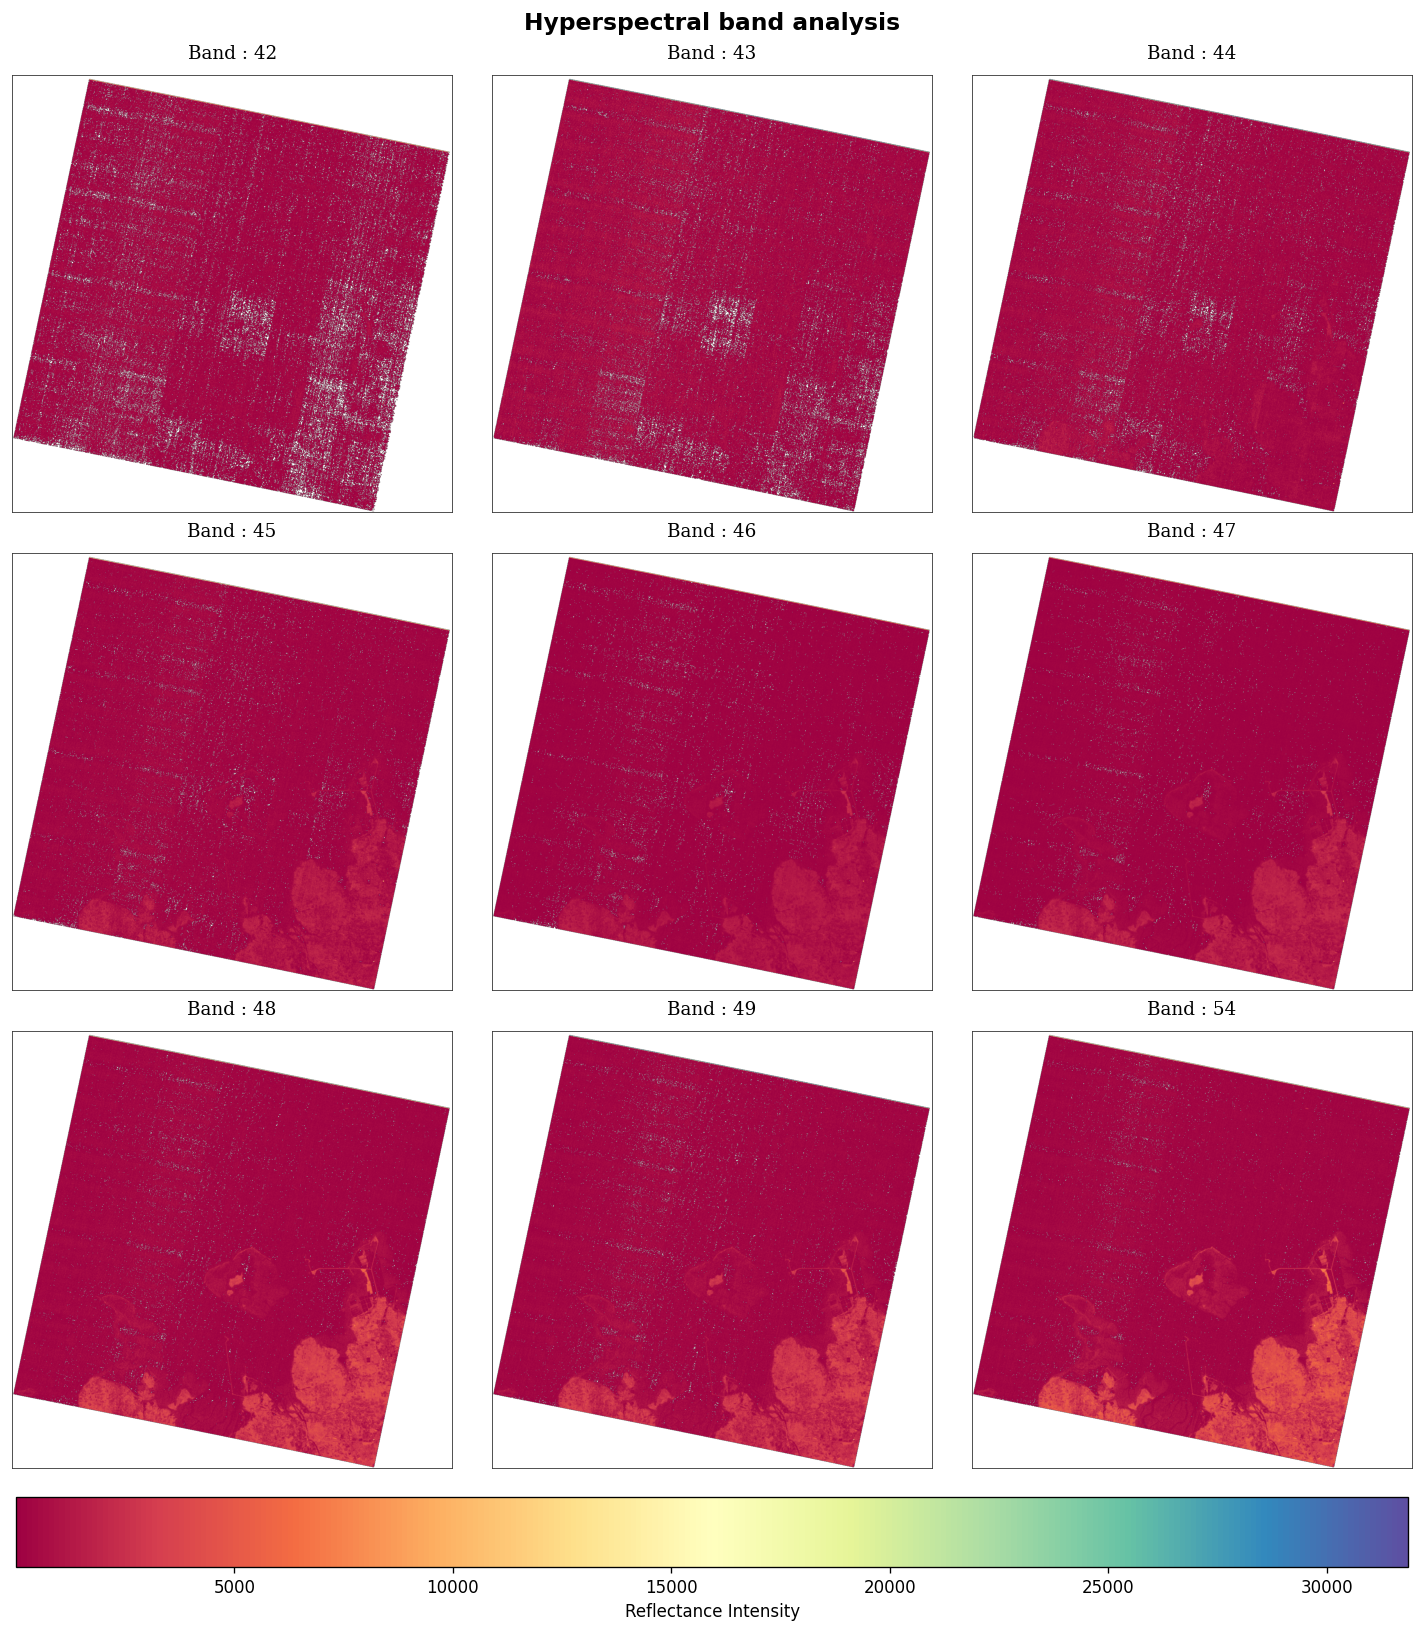

In [70]:
import math
num_plots = len(bands_to_visualize)
num_rows = math.ceil(num_plots / 3)

# Set up the plot
# Set up the plot
fig, axes = plt.subplots(
    num_rows,
    3,
    figsize=(4 * 3, 4.5 * num_rows),
    constrained_layout=True,
    dpi=120,
)

fig.suptitle(
    f"Hyperspectral band analysis",
    fontsize=14,
    fontweight="bold",
)
axes_flat = axes.flatten() if num_plots > 1 else [axes]
plot_images = []


## Do the actual plotting
for i, ax in enumerate(axes_flat):
    if i < num_plots:
        single_band = raw_cube[:,:,i]
        im = ax.imshow(single_band, cmap="Spectral")
        plot_images.append(im)
        label_text = f"Band : {bands_to_visualize[i]}"
        ax.set_title(label_text, fontsize=11, fontfamily="serif", pad=10)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor("#333333")
            spine.set_linewidth(0.5)
    else:
        ax.axis("off")
# visualize the band
if plot_images:
    cbar = fig.colorbar(
        plot_images[-1],
        ax=axes,
        orientation="horizontal",
        fraction=0.05,
        pad=0.02,
    )
    cbar.set_label("Reflectance Intensity", fontsize=10)
plt.savefig(f"assets/test_normalized_multibands.jpg")


